<a href="https://colab.research.google.com/github/NguyenHieu201/DeepChessProject/blob/main/Copy_of_DNNChess.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import package and library

In [ ]:
import chess.pgn
from io import StringIO
import itertools
import re
import random
import pandas as pd

In [ ]:
!gdown 'http://ccrl.chessdom.com/ccrl/4040/CCRL-4040.[1368576].pgn.7z'
!7z e 'CCRL-4040.[1368576].pgn.7z'

Downloading...
From: http://ccrl.chessdom.com/ccrl/4040/CCRL-4040.[1368576].pgn.7z
To: /content/CCRL-4040.[1368576].pgn.7z
100% 268M/268M [00:10<00:00, 25.5MB/s]

7-Zip [64] 16.02 : Copyright (c) 1999-2016 Igor Pavlov : 2016-05-21
p7zip Version 16.02 (locale=en_US.UTF-8,Utf16=on,HugeFiles=on,64 bits,2 CPUs Intel(R) Xeon(R) CPU @ 2.20GHz (406F0),ASM,AES-NI)

Scanning the drive for archives:
  0M Scan         1 file, 267814200 bytes (256 MiB)

Extracting archive: CCRL-4040.[1368576].pgn.7z
--
Path = CCRL-4040.[1368576].pgn.7z
Type = 7z
Physical Size = 267814200
Headers Size = 170
Method = PPMD
Solid = -
Blocks = 1

  0%      0% - CCRL-4040.[1368576].pgn                                1% - CCRL-4040.[1368576].pgn                                2% - CCRL-4040.[1368576].pgn                              

# Read pgn data to get chess game

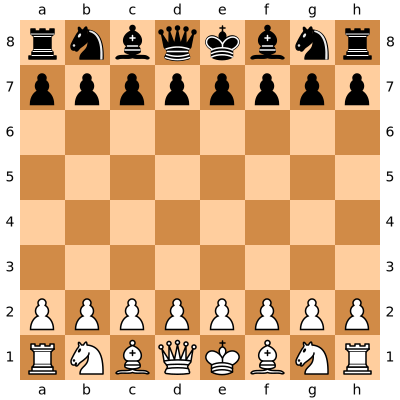

r n b q k b n r
p p p p p p p p
. . . . . . . .
. . . . . . . .
. . . P . . . .
. . . . . . . .
P P P . P P P P
R N B Q K B N R


In [ ]:
pgnPath = '/content/CCRL-4040.[1368576].pgn'
source_game = open(pgnPath, encoding='utf-8')
number_game = 50000
first_game = chess.pgn.read_game(source_game)

board = chess.Board()
display(board)
for move in itertools.islice(first_game.main_line(), 1):
    board.push(move)
    print(board)

## Read all game from file: 1,368,576 games
# while True:
#     game = chess.pgn.read_game(source_game)
#     if game is None:
#         break

#     nog += 1

# Convert board_state to bit string (773 bits)

In [ ]:
class Encode_Game:
    def __init__(self):
        self.chess_bit = {}
        

        self.make_chess_bit()

    def make_chess_bit(self):
        thisDict = { 'p': 0, 'n': 1, 'b': 2, 'r': 3, 'q': 4, 'k': 5, 'P': 6, 'N': 7, 'B': 8, 'R': 9, 'Q': 10, 'K': 11, '.': 12}

        # make chess_bit

        for chessmate in thisDict:
            if chessmate == '.':
                self.chess_bit[chessmate] =  "000000000000"
                continue
            result = ""
            pos = thisDict[chessmate]
            for i in range(0, 12):
                if (i == pos):
                    result += "1"
                else:
                    result += "0"
            self.chess_bit[chessmate] = result

    def castle_black_white(self, board_state):
        add_bit_1 = int(board_state.has_kingside_castling_rights(color=chess.WHITE))
        add_bit_2 = int(board_state.has_queenside_castling_rights(color=chess.WHITE))
        add_bit_3 = int(board_state.has_kingside_castling_rights(color=chess.BLACK))
        add_bit_4 = int(board_state.has_queenside_castling_rights(color=chess.BLACK))
        return str(add_bit_1) + str(add_bit_2) + str(add_bit_3) + str(add_bit_4)

    def make_bit_string_for_board(self, board_state):
        result = ""
        for chess_cell in re.sub(r"[\n\t\s]*","", str(board_state)):
            result += str(self.chess_bit[chess_cell])
        result += str(int(board_state.turn))
        result += self.castle_black_white(board_state=board_state)
        return result

# Get board state from game

In [ ]:
class Board_State_Filter:
    def __init__(self):
        self.encode_game = Encode_Game()
        self.iteration = 0

    def get_board_state_need(self, chess_game):
        board_game = chess.Board()
        result = chess_game.headers['Result']
        board_state_list = []

        for move in chess_game.main_line():
            self.iteration += 1
            # remove 5 first move
            if self.iteration <= 5:
                continue
            if board_game.is_capture(move):
                board_game.push(move)
            else:
                board_game.push(move)
                board_state_list.append(self.encode_game.make_bit_string_for_board(board_state=board_game))
        return (result, board_state_list)        

# Get dataset
Get 10,000 game for white-win and black-win
10 move for each game

In [ ]:
pgnPath = '/content/CCRL-4040.[1368576].pgn'
source_game = open(pgnPath, encoding='utf-8')
number_game = 50000
board_state_filter = Board_State_Filter()
black_win = []
white_win = []

for game in range(0, 50000):
    game = chess.pgn.read_game(source_game)
    # res, board_list = board_state_filter.get_board_state_need(chess_game=game)
    if game.headers['Result'] == '1-0':
        white_win.append(game)
    else:
        black_win.append(game)


In [ ]:
# black-win
black_win = random.sample(black_win, 10000)
white_win = random.sample(white_win, 10000)
bwin_state = []
wwin_state = []

for game in black_win:
    res, board_list = board_state_filter.get_board_state_need(chess_game=first_game)
    tmp = random.sample(board_list, 10)
    for state in tmp:
        bwin_state.append(state)
    
for game in white_win:
    res, board_list = board_state_filter.get_board_state_need(chess_game=first_game)
    tmp = random.sample(board_list, 10)
    for state in tmp:
        wwin_state.append(state)

In [ ]:
data_frame = pd.DataFrame(bwin_state, columns=['Game_State'])
data_frame.to_csv('bwin.csv')
data_frame = pd.DataFrame(wwin_state, columns=['GameState'])
data_frame.to_csv('wwin.csv')

In [ ]:
#Autoencoder
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, losses
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.models import Model

#convert bitstring to float32 numpy array
def convert_bitstring(btstr):
  res=np.zeros((1,len(btstr)))
  for i in range(len(btstr)):
    if btstr[i] == "1":
      res[0][i] = 1
    else:
      res[0][i] = 0
  return res
 

latent_dim = 4 

class Autoencoder(Model):
  def __init__(self, latent_dim):
    super(Autoencoder, self).__init__()
    self.latent_dim = latent_dim   
    self.encoder = tf.keras.Sequential([
      layers.Flatten(),
      layers.Dense(latent_dim, activation='relu')
    ])
    self.decoder = tf.keras.Sequential([
      layers.Dense(6, activation='sigmoid'),
      layers.Reshape((1,6))
    ])

  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded
  def bottle_neck(self,x):
    encoded = self.encoder(x)
    return encoded

autoencoder = Autoencoder(latent_dim)

autoencoder.compile(optimizer='adam', loss=losses.MeanSquaredError())

In [ ]:
# untested code
# Fully Connected Layers
class FCLayers(Model):
  def __init__(self):
    super(FCLayers,self).__init__()
    self.feed = tf.keras.Sequential([
        layers.Flatten(),
        layers.Dense(400),
        layers.Dense(200),
        layers.Dense(100),
        layers.Dense(2)
    ])
  def call(self,x):
    result = self.feed(x)
    return result
fc_layer = FCLayers()
fc_layer.compile(optimizer='adam',loss=losses.MeanSquaredError())


In [ ]:
# TODO: Change point into board update then apply compare 

# PSUEDOCODE
def compare(board1,board2):
  return board1>board2
# MINIMAX



class MiniMax:
  def __init__(self,depth):
    self._depth = depth
  def minimax(board,maximize_player,alpha_board,beta_board,depth):
    
    if depth == 0 or game_over(board):
      return board
    if maximize_player:
      max_eval = - infinite
      for e in board.legalmove:
        eval = minimax(board.move(),false,alpha_board,beta_board,depth-1)
        max_eval = max(max_eval,eval)
        alpha_board = max(alpha_board,eval)
        if alpha_board>=beta_board:
          break

      return max_eval
    if not maximize_player:
      min_eval = infinite
      for e in board.legalmove:
        eval = minimax(board.move(),true,alpha_board,beta_board,depth-1)
        min_eval = min(eval,min_eval)
        beta_board = min(eval,beta_board)
        if alpha_board >= beta_board:
          break
      return min_eval
    
    



In [ ]:
autoencoder.encoder.build((1,773))

In [ ]:
autoencoder.encoder.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_5 (Flatten)         (1, 773)                  0         
                                                                 
 dense_10 (Dense)            (1, 4)                    3096      
                                                                 
Total params: 3,096
Trainable params: 3,096
Non-trainable params: 0
_________________________________________________________________


# Test anything you want

In [ ]:
string = first_game.headers['Result']
if string == '1-0':
    print('Ok')

Ok


In [ ]:
board_state_filter = Board_State_Filter()
res, board_list = board_state_filter.get_board_state_need(chess_game=first_game)

In [ ]:
tmp = random.sample(board_list, 10)
temp = []
temp.append(tmp)
len(temp)

1

In [ ]:
res = convert_bitstring("100111")
res2 = convert_bitstring("111111")
res3 = convert_bitstring("101010")
res4 = convert_bitstring("111000")
res5 = convert_bitstring("000111")
res_final=np.array([res,res2,res3,res4,res5])

#res = np.array([res])
#print(res)
test_res = convert_bitstring("100101")
#test_res = np.array([test_res])
#print(test_res)


In [ ]:
res_final.shape
print(res.shape)
layer = layers.Flatten()
input = layer(res_final)
print(input)

(1, 6)
tf.Tensor(
[[1. 0. 0. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1.]], shape=(2, 6), dtype=float32)


In [ ]:
autoencoder.compile(optimizer='adam', loss=losses.MeanSquaredError())


In [ ]:
autoencoder.fit(res_final, res_final,
                epochs=10000,
                shuffle=True,
                validation_data=(test_res, test_res))


Streaming output truncated to the last 5000 lines.
1/1 [==============================] - 0s 45ms/step - loss: 0.0456 - val_loss: 0.2096
Epoch 7502/10000
1/1 [==============================] - 0s 47ms/step - loss: 0.0456 - val_loss: 0.2096
Epoch 7503/10000
1/1 [==============================] - 0s 39ms/step - loss: 0.0456 - val_loss: 0.2096
Epoch 7504/10000
1/1 [==============================] - 0s 56ms/step - loss: 0.0456 - val_loss: 0.2096
Epoch 7505/10000
1/1 [==============================] - 0s 35ms/step - loss: 0.0456 - val_loss: 0.2096
Epoch 7506/10000
1/1 [==============================] - 0s 44ms/step - loss: 0.0456 - val_loss: 0.2096
Epoch 7507/10000
1/1 [==============================] - 0s 37ms/step - loss: 0.0456 - val_loss: 0.2096
Epoch 7508/10000
1/1 [==============================] - 0s 47ms/step - loss: 0.0456 - val_loss: 0.2096
Epoch 7509/10000
1/1 [==============================] - 0s 39ms/step - loss: 0.0456 - val_loss: 0.2096
Epoch 7510/10000
1/1 [=================

In [ ]:
autoencoder.call(test_res)

<tf.Tensor: shape=(1, 1, 6), dtype=float32, numpy=
array([[[0.5012582 , 0.20258632, 0.03383052, 0.99647045, 0.992352  ,
         0.99641454]]], dtype=float32)>

In [ ]:
autoencoder.bottle_neck(test_res)

<tf.Tensor: shape=(1, 4), dtype=float32, numpy=array([[0., 0., 0., 0.]], dtype=float32)>

In [ ]:
fc_layer.fit()